In [267]:
import pandas as pd
import numpy as np
import os
from  sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import requests
import json


## 透過API讀取資料庫爬取的資料

In [268]:
df = requests.get("http://127.0.0.1:5000/branch_api")
data = pd.DataFrame(json.loads(df.text))

## DROP掉股價資訊保留三大法人及分點進出資料

In [269]:
data["Close_log"] = data["Close"].shift(1)
data["Close_log"] = (data["Close_log"] - data["Close"])/data["Close"]
dd = data[["Open","High","Low","Close","Volume","Dividends","Stock Splits","stock_id","Close_log"]]
data.drop(["Open","High","Low","Close","Volume","Dividends","Stock Splits","stock_id","time","Close_log"],axis=1, inplace=True)
data.fillna(0,inplace=True)

## 測試三種異常
1. 三大法人(bid3_data)
2. 分點進出(branch_data)
3. 三大法人+分點進出(data)

In [270]:
big3_data = data[['三大法人買賣超股數', '外資自營商買賣超股數', '外資自營商買進股數', '外資自營商賣出股數',
       '外資買賣超股數', '外資買進股數', '外資賣出股數', '外陸資買賣超股數(不含外資自營商)', '外陸資買進股數(不含外資自營商)',
       '外陸資賣出股數(不含外資自營商)', '投信買賣超股數', '投信買進股數', '投信賣出股數', '自營商買賣超股數',
       '自營商買賣超股數(自行買賣)', '自營商買賣超股數(避險)', '自營商買進股數', '自營商買進股數(自行買賣)',
       '自營商買進股數(避險)', '自營商賣出股數', '自營商賣出股數(自行買賣)', '自營商賣出股數(避險)']]

branch_data = data.drop(['三大法人買賣超股數', '外資自營商買賣超股數', '外資自營商買進股數', '外資自營商賣出股數',
       '外資買賣超股數', '外資買進股數', '外資賣出股數', '外陸資買賣超股數(不含外資自營商)', '外陸資買進股數(不含外資自營商)',
       '外陸資賣出股數(不含外資自營商)', '投信買賣超股數', '投信買進股數', '投信賣出股數', '自營商買賣超股數',
       '自營商買賣超股數(自行買賣)', '自營商買賣超股數(避險)', '自營商買進股數', '自營商買進股數(自行買賣)',
       '自營商買進股數(避險)', '自營商賣出股數', '自營商賣出股數(自行買賣)', '自營商賣出股數(避險)'],axis = 1)

In [271]:
big3_data.head()

,三大法人買賣超股數,外資自營商買賣超股數,外資自營商買進股數,外資自營商賣出股數,外資買賣超股數,外資買進股數,外資賣出股數,外陸資買賣超股數(不含外資自營商),外陸資買進股數(不含外資自營商),外陸資賣出股數(不含外資自營商),...,投信賣出股數,自營商買賣超股數,自營商買賣超股數(自行買賣),自營商買賣超股數(避險),自營商買進股數,自營商買進股數(自行買賣),自營商買進股數(避險),自營商賣出股數,自營商賣出股數(自行買賣),自營商賣出股數(避險)
2020-06-01,9213639.0,0.0,0.0,0.0,21594860.0,30676499.0,21594860.0,9081639.0,30676499.0,21594860.0,...,178000.0,145000.0,63000.0,82000.0,747000.0,137000.0,610000.0,602000.0,74000.0,528000.0
2020-06-02,4506125.0,0.0,0.0,0.0,14919240.0,19133365.0,14919240.0,4214125.0,19133365.0,14919240.0,...,33000.0,84000.0,1000.0,83000.0,311000.0,64000.0,247000.0,227000.0,63000.0,164000.0
2020-06-03,19499481.0,0.0,0.0,0.0,28057503.0,42710984.0,28057503.0,14653481.0,42710984.0,28057503.0,...,95000.0,4470000.0,4039000.0,431000.0,4662000.0,4081000.0,581000.0,192000.0,42000.0,150000.0
2020-06-04,15637966.0,0.0,0.0,0.0,15734404.0,30500370.0,15734404.0,14765966.0,30500370.0,15734404.0,...,97000.0,467000.0,187000.0,280000.0,1120000.0,432000.0,688000.0,653000.0,245000.0,408000.0
2020-06-05,20888320.0,0.0,0.0,0.0,11867921.0,31702241.0,11867921.0,19834320.0,31702241.0,11867921.0,...,93000.0,768000.0,188000.0,580000.0,1192000.0,289000.0,903000.0,424000.0,101000.0,323000.0


In [272]:
branch_data.head()

,中國信託(buy),中國信託(sell),中國信託-三重(buy),中國信託-三重(sell),中國信託-中壢(buy),中國信託-中壢(sell),中國信託-嘉義(buy),中國信託-嘉義(sell),中國信託-忠孝(buy),中國信託-忠孝(sell),...,高橋(buy),高橋(sell),高橋-中壢(buy),高橋-中壢(sell),高橋-內壢(buy),高橋-內壢(sell),高橋-龍潭(buy),高橋-龍潭(sell),亞鑫豐(buy),亞鑫豐(sell)
2020-06-01,2,22,6,44,2,18,0,4,10,29,...,0,11,0.0,0.0,1,7,2,12,12,191
2020-06-02,3,35,3,2,3,4,1,3,2,37,...,1,17,2.0,0.0,10,5,51,11,15,44
2020-06-03,64,119,4,30,6,50,4,25,9,78,...,35,55,0.0,6.0,6,17,9,66,156,76
2020-06-04,119,79,15,19,12,26,2,12,5,38,...,23,32,5.0,4.0,14,21,15,38,33,62
2020-06-05,196,108,18,23,11,11,6,14,20,32,...,11,49,0.0,4.0,0,27,3,21,11,81


## 訓練isolationForest 
### 偵測異常三大法人進出

In [273]:
model_big_3 = IsolationForest(contamination= 0.2 , max_samples="auto",
                        max_features=len(big3_data.columns),n_estimators=1000,
                        n_jobs=-1,bootstrap=False
                        )

In [274]:
pred_big_3  = model_big_3.fit_predict(big3_data)

In [275]:
big3_data.loc[:,"anomaly"] = pred_big_3
big3_data.loc[:,"Close"] = dd.loc[:,"Close"]
big3_data.loc[:,"Close_log"] = dd.loc[:,"Close_log"]

/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

### 偵測異常分點進出

In [276]:
model_branch_data = IsolationForest(contamination= 0.2, max_samples="auto",
                        max_features=len(branch_data.columns),n_estimators=1000,
                        n_jobs=-1,bootstrap=False
                        )

In [277]:
pred_branch_data  = model_branch_data.fit_predict(branch_data)

In [278]:
branch_data.loc[:,"anomaly"] = pred_branch_data
branch_data.loc[:,"Close"] = dd.loc[:,"Close"]
branch_data.loc[:,"Close_log"] = dd.loc[:,"Close_log"]

### 全部資料

In [279]:
model_data = IsolationForest(contamination= 0.2, max_samples="auto",
                        max_features=len(data.columns),n_estimators=1000,
                        n_jobs=-1,bootstrap=False
                        )

In [280]:
pred_data  = model_data.fit_predict(data)

In [281]:
data.loc[:,"anomaly"] = pred_data
data.loc[:,"Close"] = dd.loc[:,"Close"]
data.loc[:,"Close_log"] = dd.loc[:,"Close_log"]

## 三大法人異常進出與股價做圖

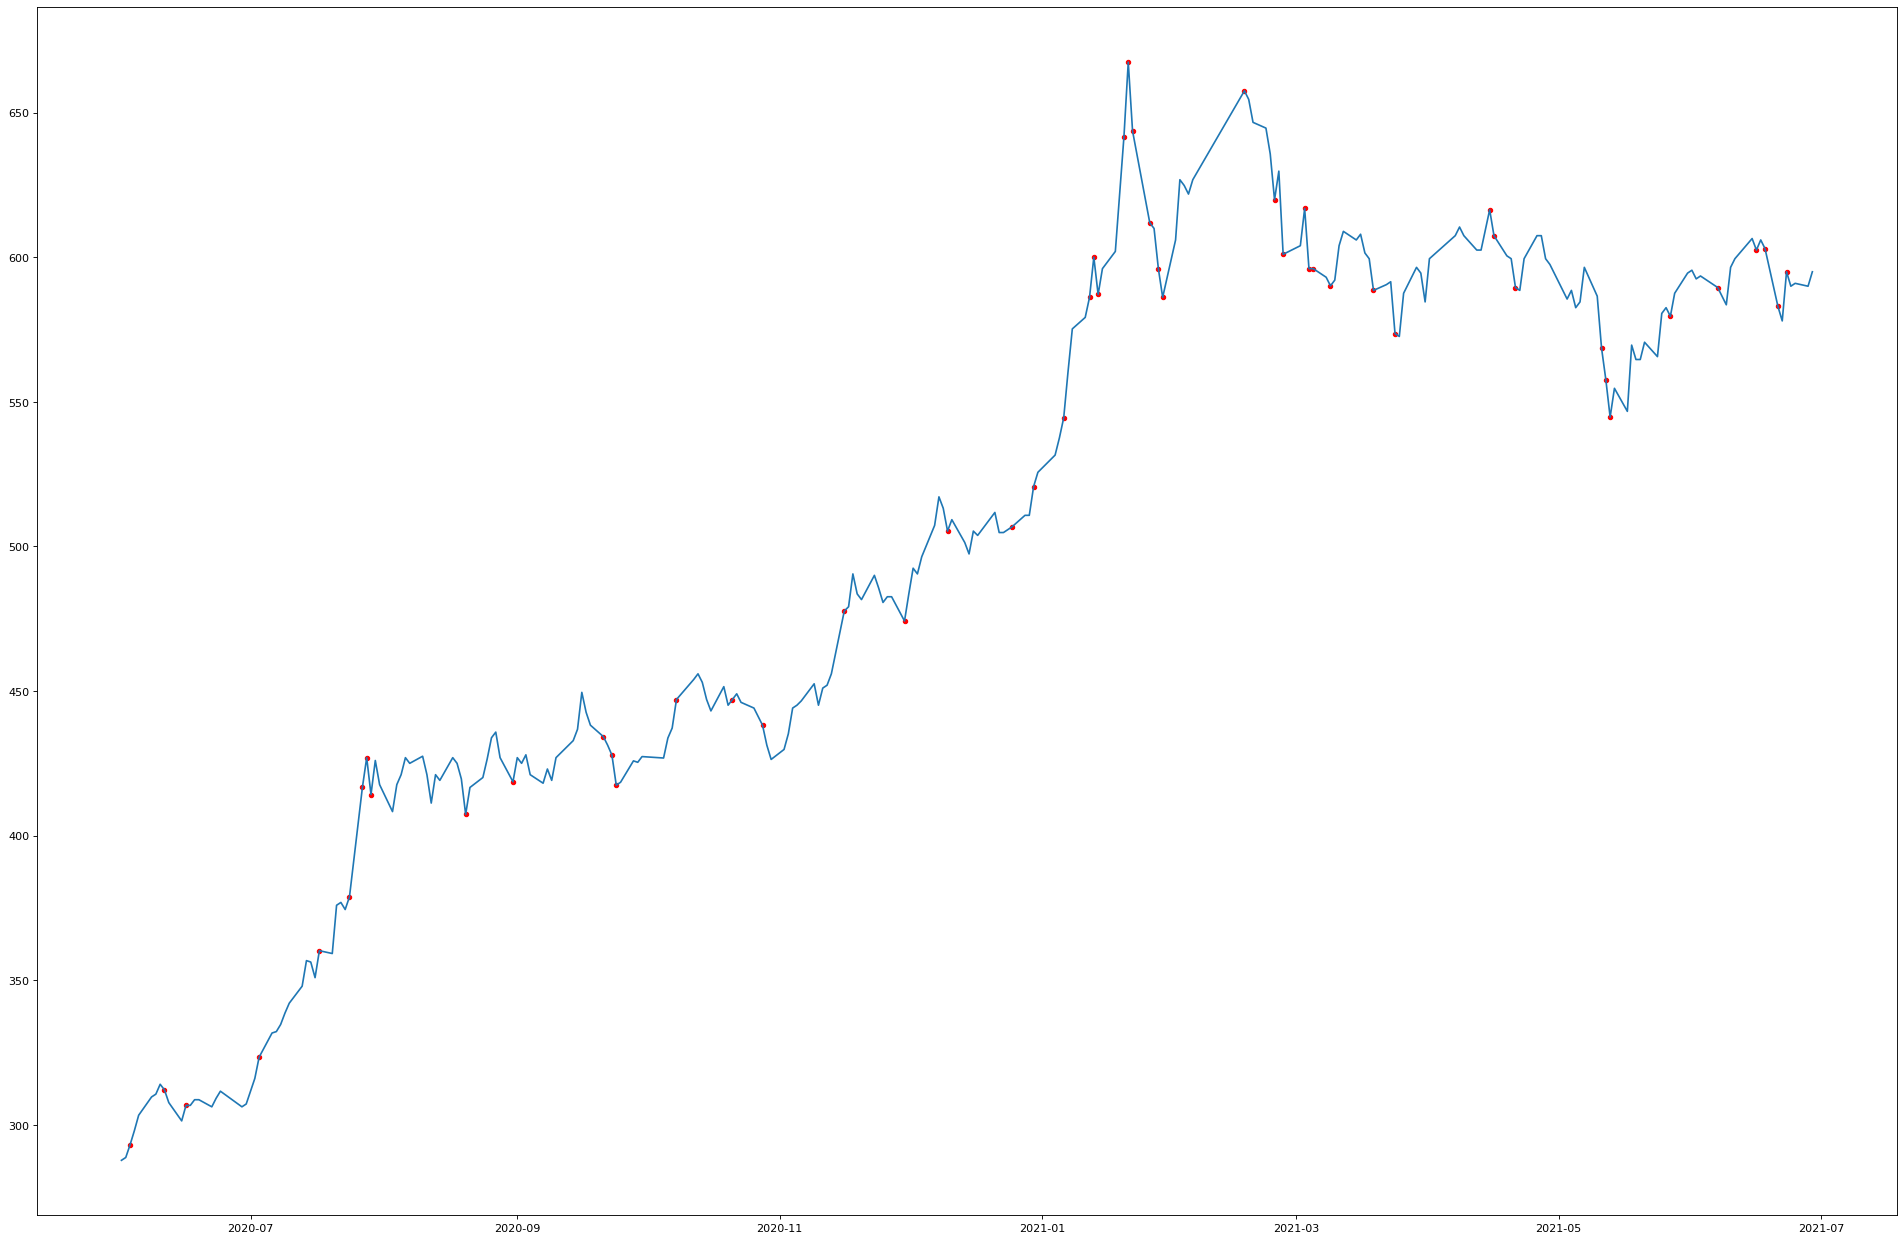

In [282]:
import  matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(30, 20), dpi=80)

plt.plot(np.array(big3_data.index.values , dtype = "datetime64[D]"), big3_data["Close"])
plt.scatter(np.array(big3_data.loc[big3_data["anomaly"] == -1 , "Close"].index.values , dtype = "datetime64[D]") , big3_data.loc[big3_data["anomaly"] == -1 , "Close"] , color = "red" , s =15  )



## 分點進出異常與股價做圖

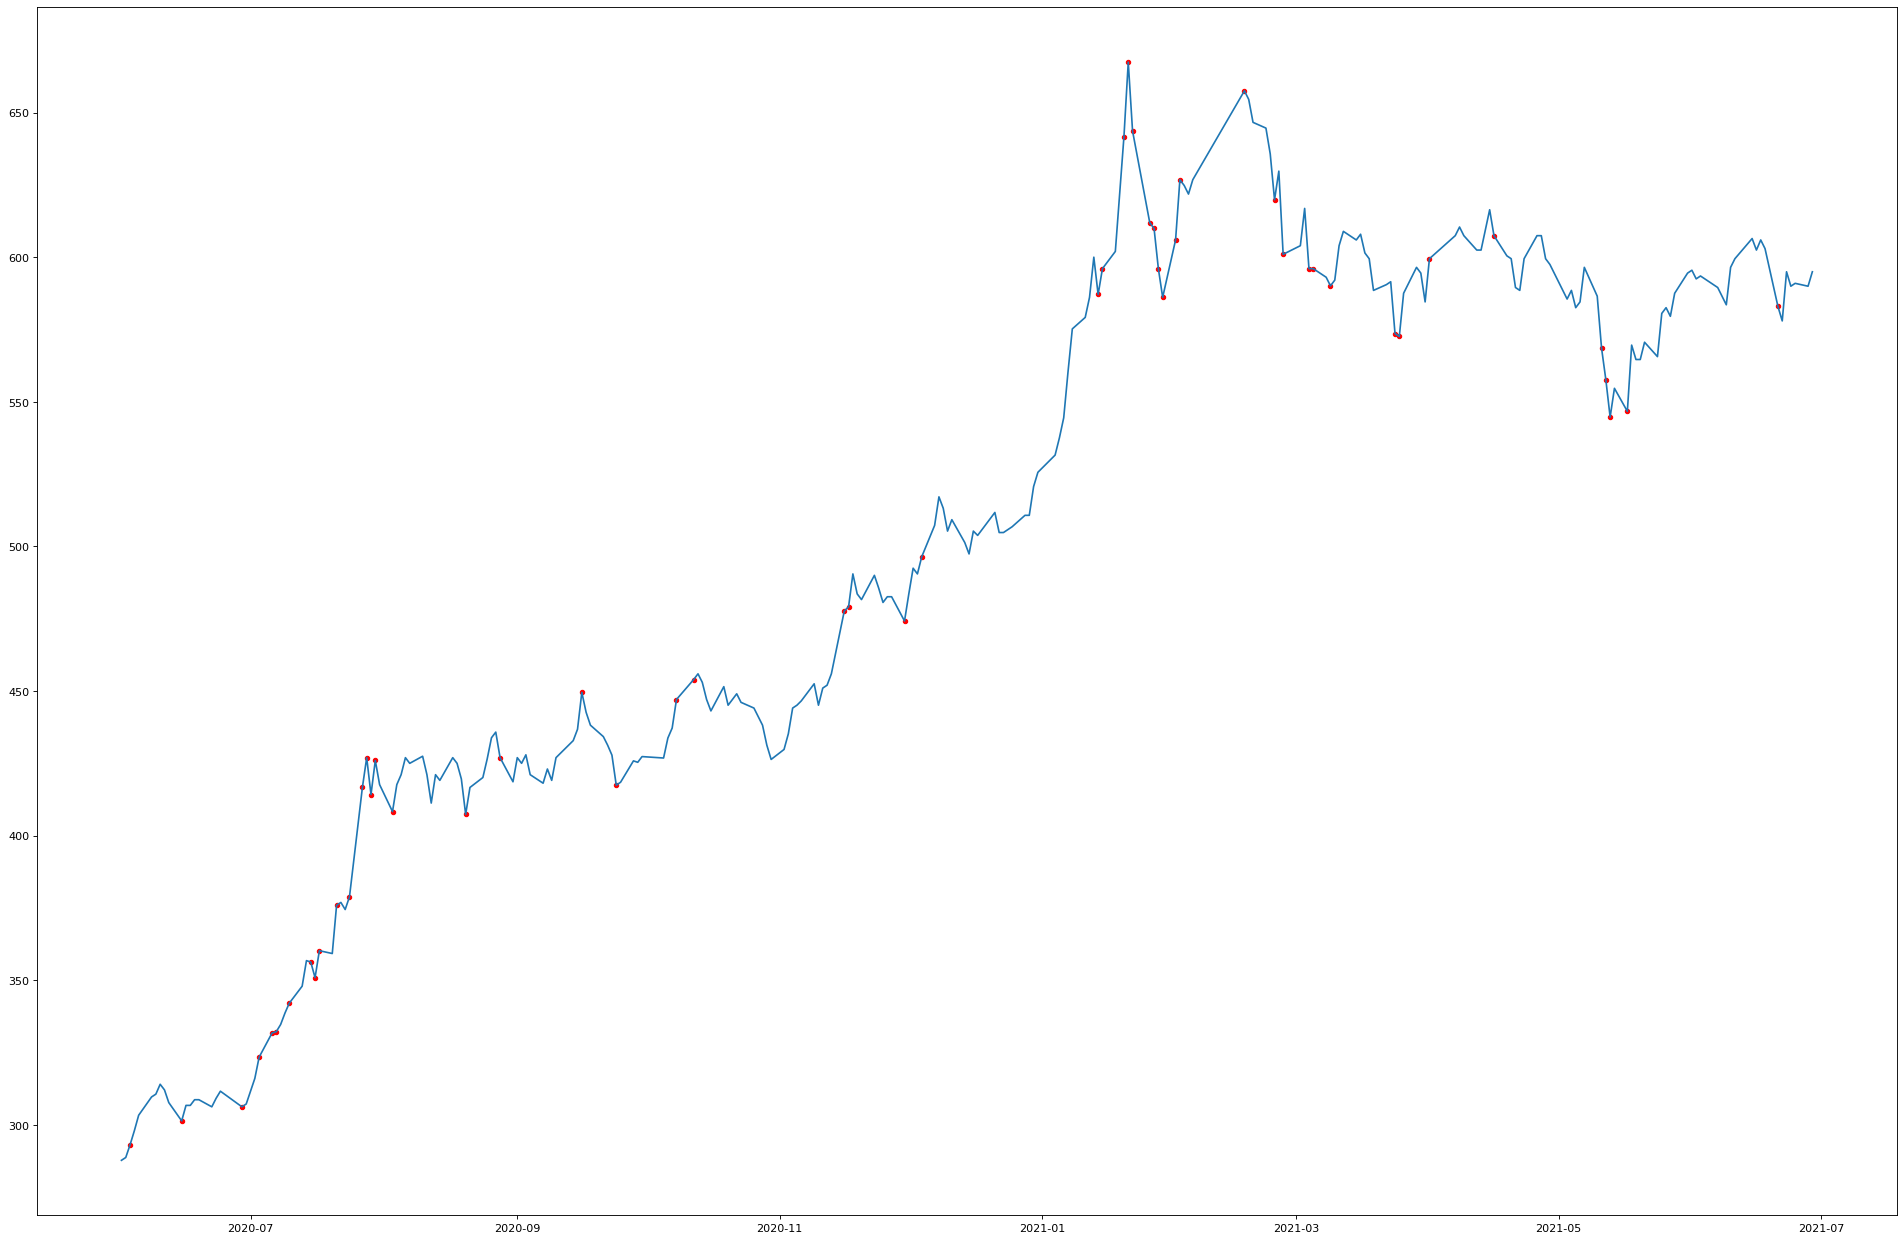

In [283]:
import  matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(30, 20), dpi=80)

plt.plot(np.array(branch_data.index.values , dtype = "datetime64[D]"), branch_data["Close"])
plt.scatter(np.array(branch_data.loc[branch_data["anomaly"] == -1 , "Close"].index.values , dtype = "datetime64[D]") , branch_data.loc[branch_data["anomaly"] == -1 , "Close"] , color = "red" , s =15  )

## 總異常進出與股價做圖

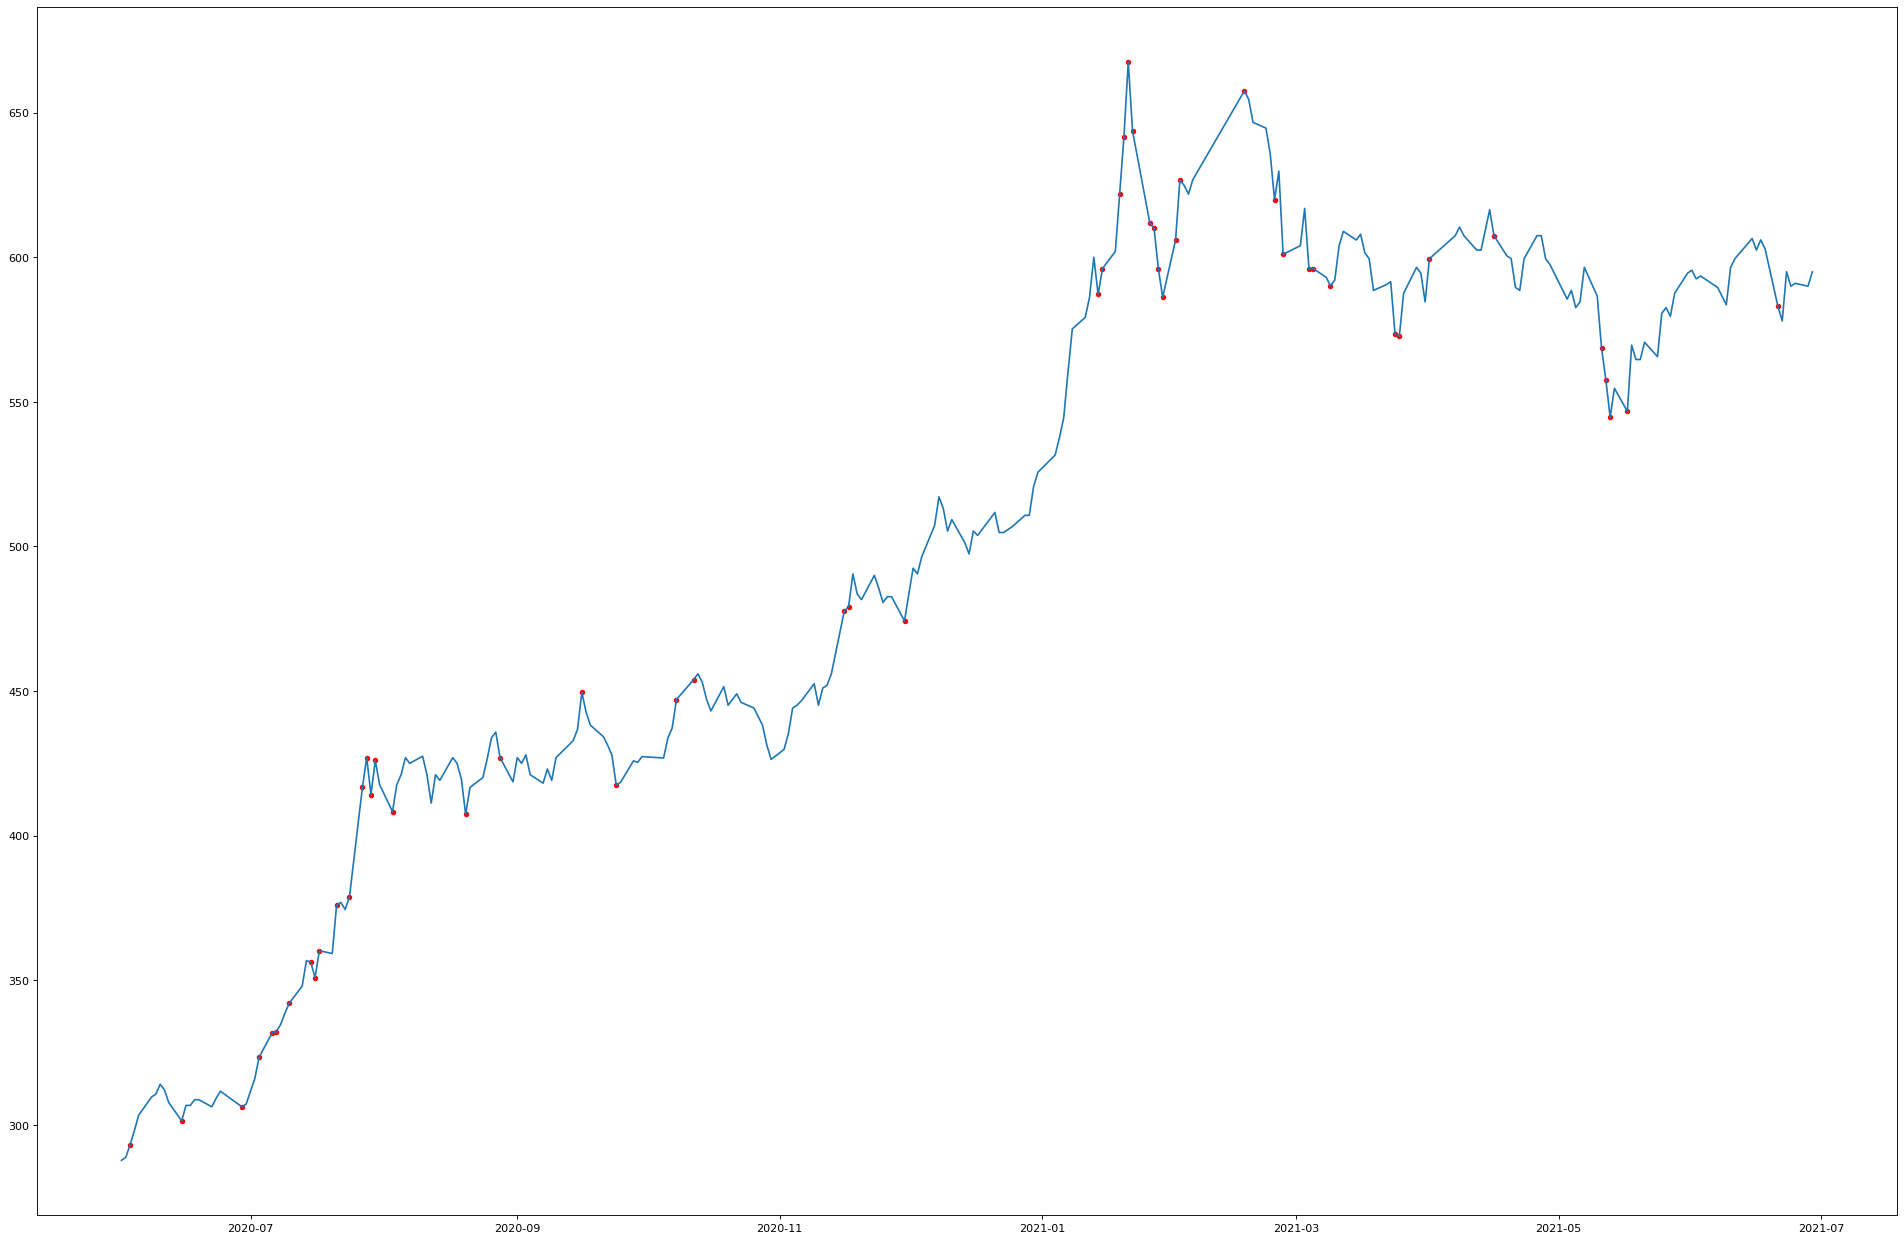

In [284]:
import  matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(30, 20), dpi=80)

plt.plot(np.array(data.index.values , dtype = "datetime64[D]"), data["Close"])
plt.scatter(np.array(branch_data.loc[data["anomaly"] == -1 , "Close"].index.values , dtype = "datetime64[D]") , data.loc[data["anomaly"] == -1 , "Close"] , color = "red" , s =15  )

## 三大法人異常發生後5日、7日、14日、30日平均波動

/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

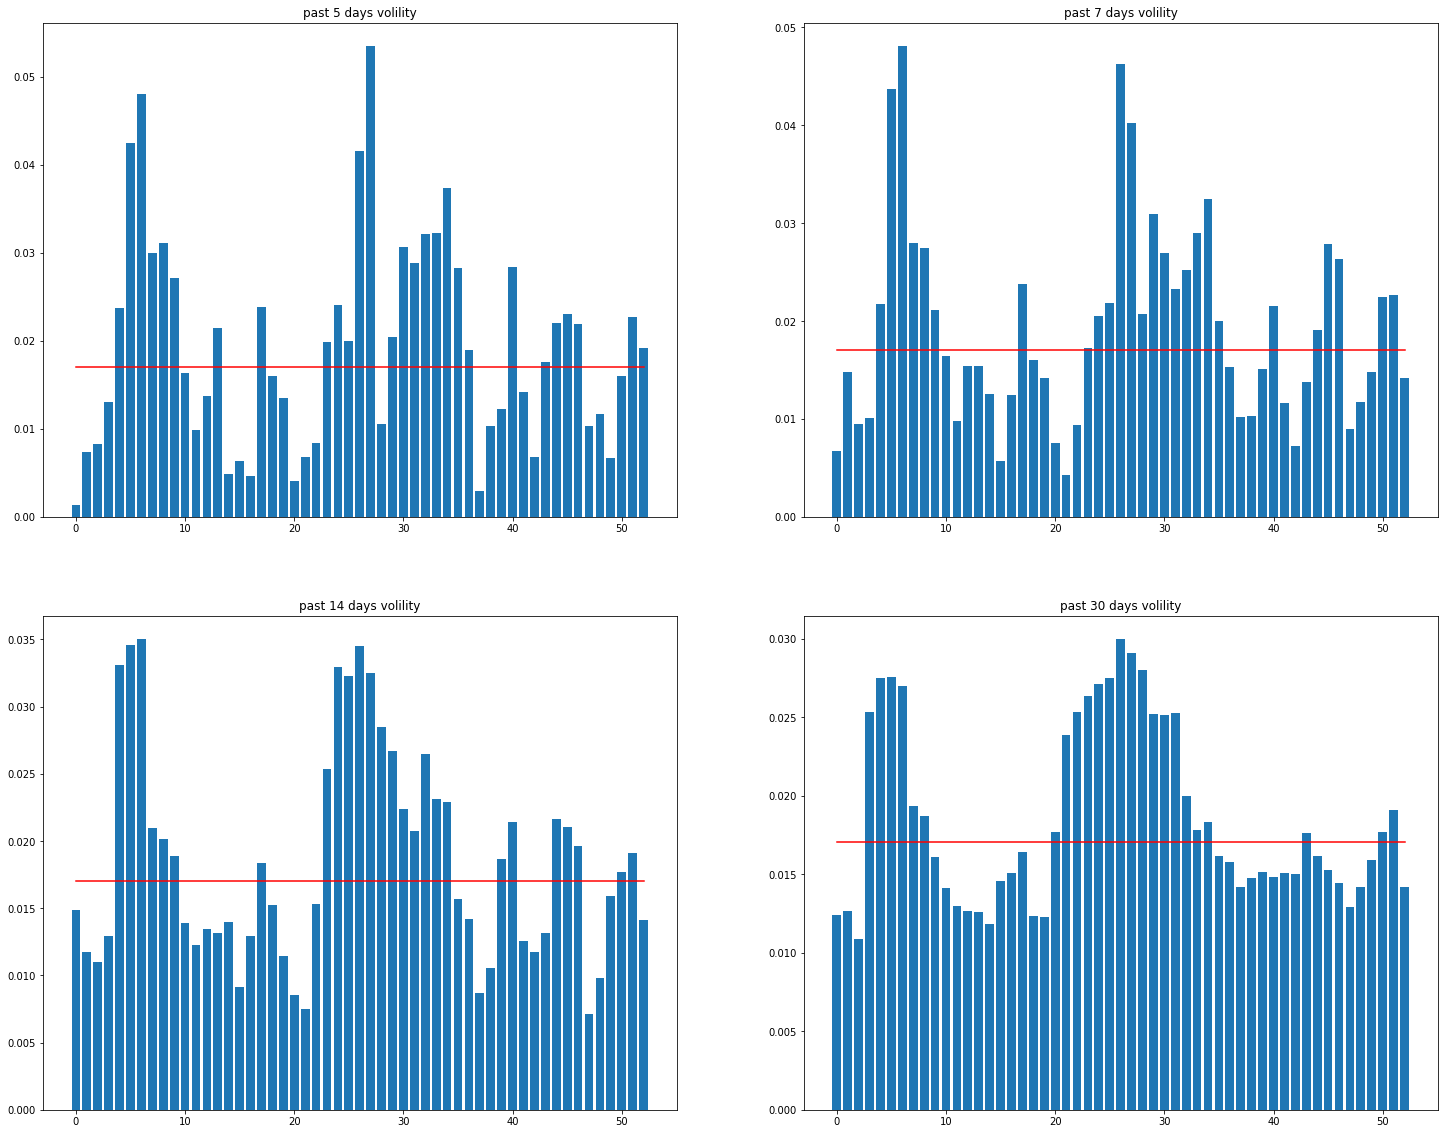

In [291]:

anomaly_date = big3_data.loc[big3_data["anomaly"] == -1 ,["Close_log"]]
anomaly_date = np.array(anomaly_date.index.values , dtype = "datetime64")

average_volility = big3_data["Close_log"].std()

def anomaly_volility_TimeStep(timestep):
    anomaly_volility = []
    for i in anomaly_date :
        date_range = np.arange(i,i+timestep)
        anomaly_volility.append(big3_data.loc[ date_range.astype(str),"Close_log" ].std())
    return anomaly_volility


fig , au = plt.subplots(2,2)
time_steps = [[5,7], [14 ,30]]

for rows , time_steps_ in enumerate(time_steps):
    for columns , time_step in enumerate(time_steps_):
        anomaly_volility = anomaly_volility_TimeStep(time_step)
        au[rows , columns].bar(np.arange(0,len(anomaly_volility)) ,anomaly_volility )
        au[rows , columns].plot(np.arange(0,len(anomaly_volility)) , [average_volility]*len(anomaly_volility) , color = "red" )
        au[rows , columns].set_title(f"past {time_step} days volility")
fig.set_figheight(20)
fig.set_figwidth(25)

## 分點進出異常發生後5日、7日、14日、30日平均波動

/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

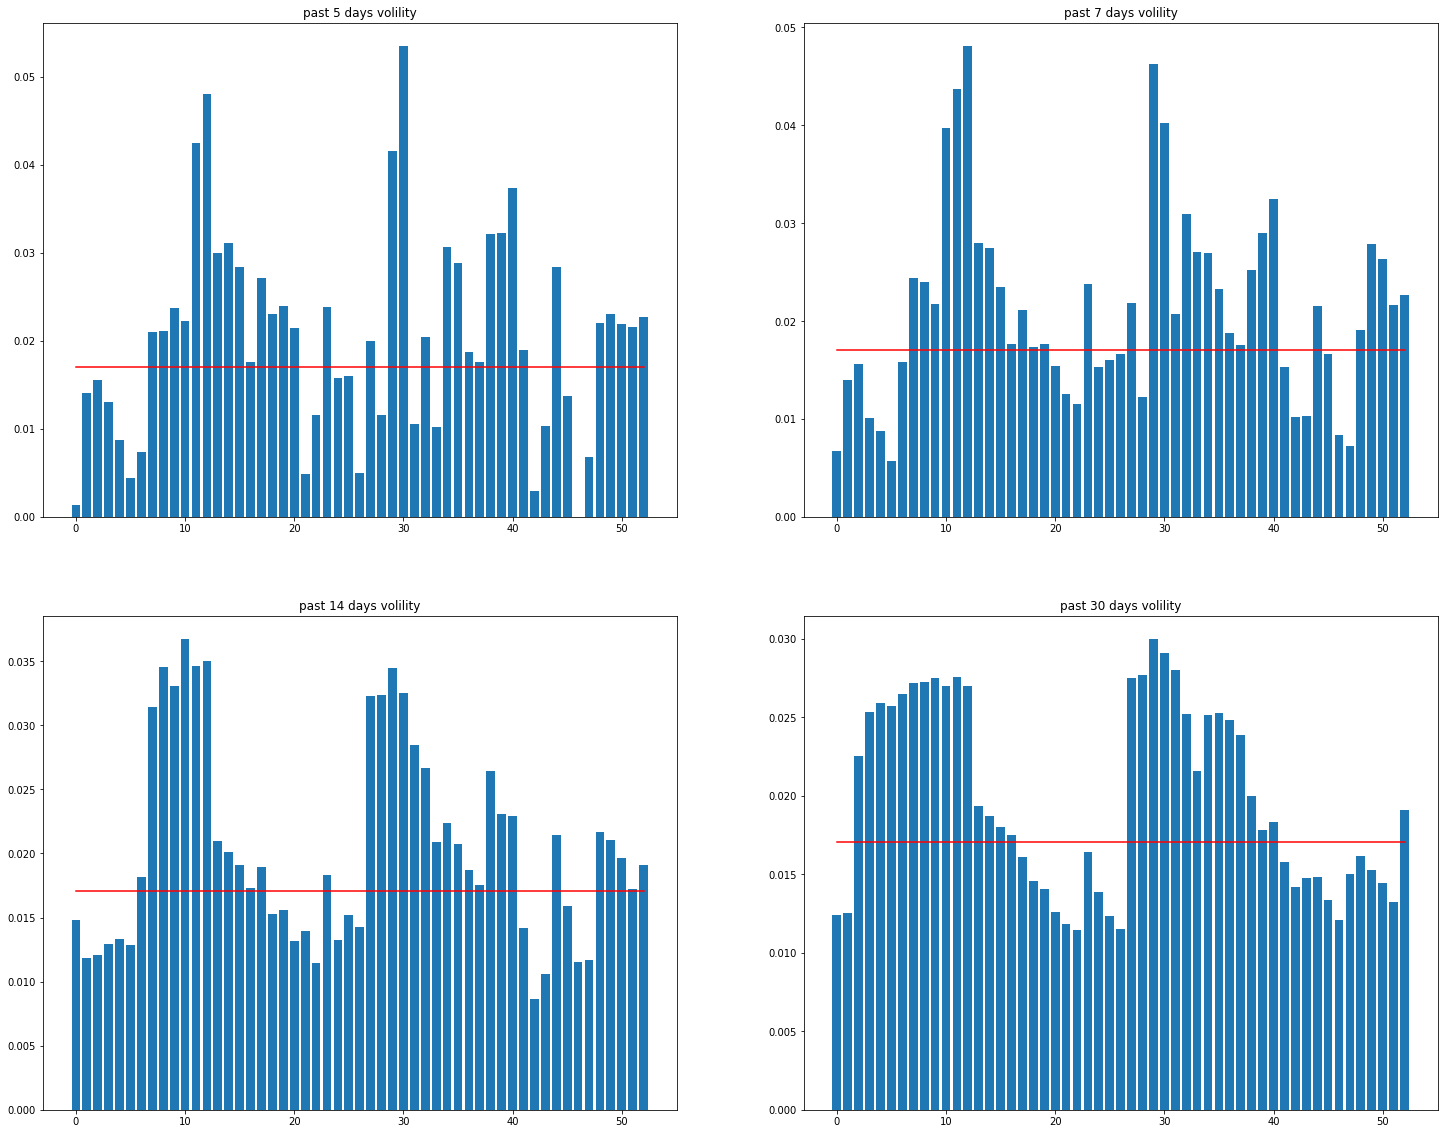

In [292]:

anomaly_date = branch_data.loc[branch_data["anomaly"] == -1 ,["Close_log"]]
anomaly_date = np.array(anomaly_date.index.values , dtype = "datetime64")

average_volility = branch_data["Close_log"].std()

def anomaly_volility_TimeStep(timestep):
    anomaly_volility = []
    for i in anomaly_date :
        date_range = np.arange(i,i+timestep)
        anomaly_volility.append(branch_data.loc[ date_range.astype(str),"Close_log" ].std())
    return anomaly_volility


fig , au = plt.subplots(2,2)
time_steps = [[5,7], [14 ,30]]

for rows , time_steps_ in enumerate(time_steps):
    for columns , time_step in enumerate(time_steps_):
        anomaly_volility = anomaly_volility_TimeStep(time_step)
        au[rows , columns].bar(np.arange(0,len(anomaly_volility)) ,anomaly_volility )
        au[rows , columns].plot(np.arange(0,len(anomaly_volility)) , [average_volility]*len(anomaly_volility) , color = "red" )
        au[rows , columns].set_title(f"past {time_step} days volility")
fig.set_figheight(20)
fig.set_figwidth(25)

## 全部異常發生後5日、7日、14日、30日平均波動

/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
/root/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the d

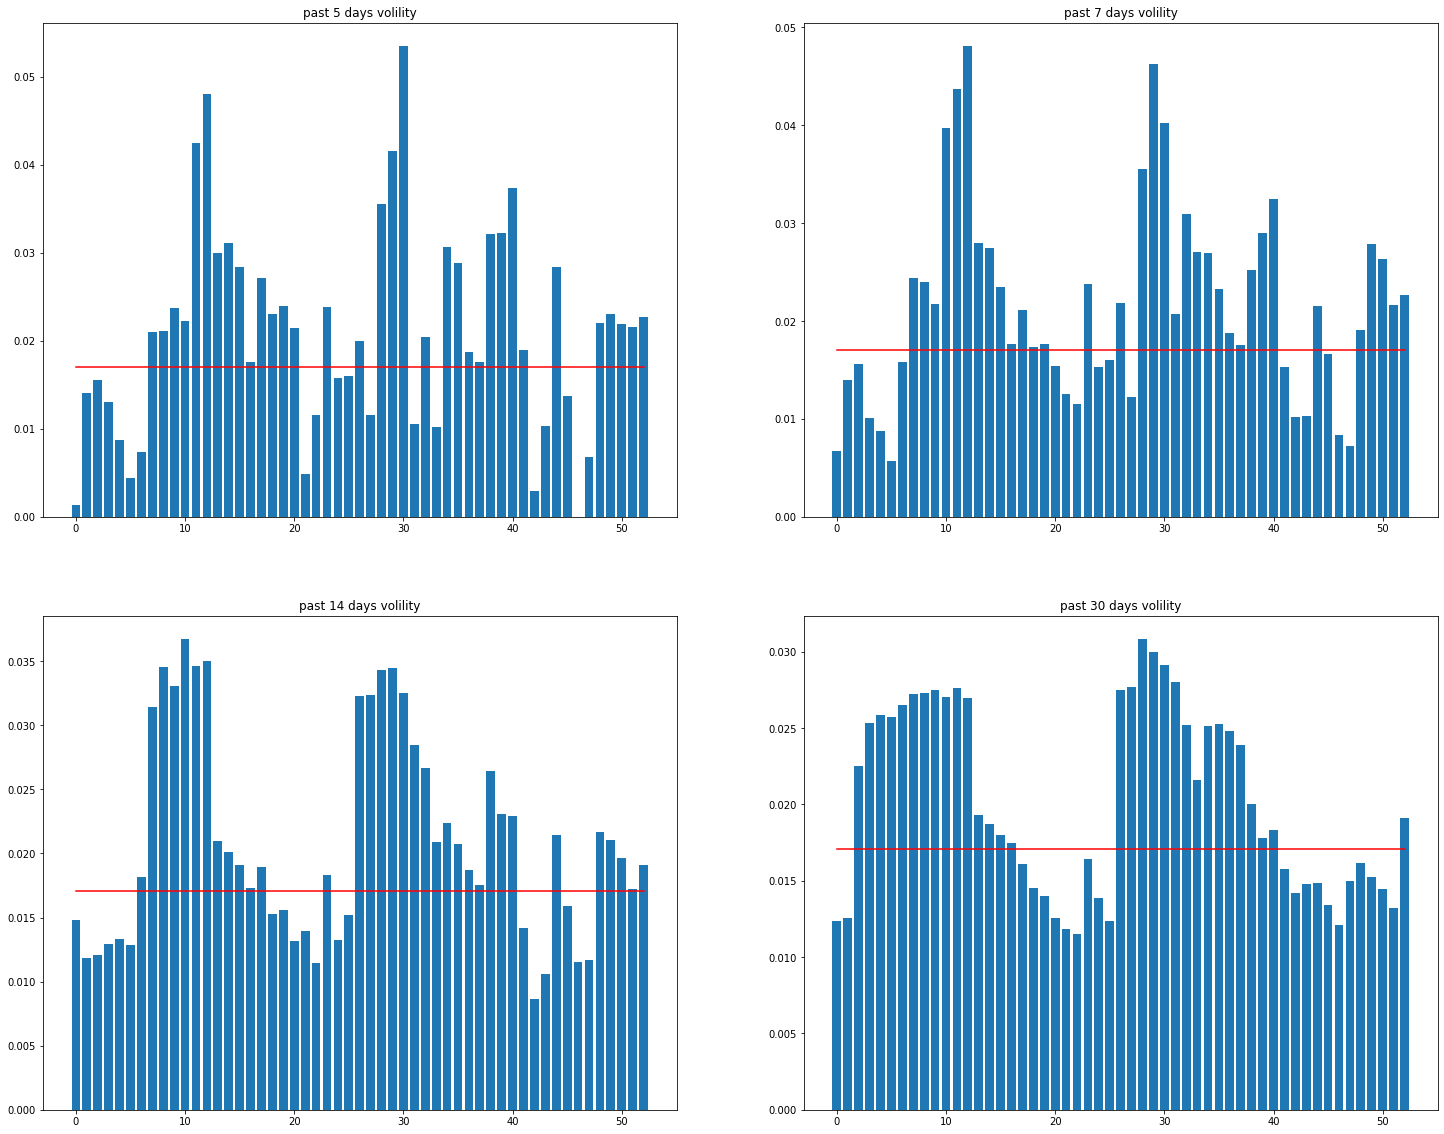

In [293]:
anomaly_date =data.loc[data["anomaly"] == -1 ,["Close_log"]]
anomaly_date = np.array(anomaly_date.index.values , dtype = "datetime64")

average_volility = data["Close_log"].std()

def anomaly_volility_TimeStep(timestep):
    anomaly_volility = []
    for i in anomaly_date :
        date_range = np.arange(i,i+timestep)
        anomaly_volility.append(data.loc[ date_range.astype(str),"Close_log" ].std())
    return anomaly_volility


fig , au = plt.subplots(2,2)
time_steps = [[5,7], [14 ,30]]

for rows , time_steps_ in enumerate(time_steps):
    for columns , time_step in enumerate(time_steps_):
        anomaly_volility = anomaly_volility_TimeStep(time_step)
        au[rows , columns].bar(np.arange(0,len(anomaly_volility)) ,anomaly_volility )
        au[rows , columns].plot(np.arange(0,len(anomaly_volility)) , [average_volility]*len(anomaly_volility) , color = "red" )
        au[rows , columns].set_title(f"past {time_step} days volility")
fig.set_figheight(20)
fig.set_figwidth(25)